In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from torchvision import models,transforms
import torch.nn as nn
import torch.utils.data as Data
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('./input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

data_path = './input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
import torch
import random
import numpy as np
import os

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
torch.backends.cudnn.enabled=False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
import pandas as pd

data_path = './input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.1,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                                random_state=42)

In [7]:
import cv2
from torch.utils.data import Dataset
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id + '.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터이면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환
        if self.is_test:
            return image
        
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [9]:
transform_train = A.Compose([
    A.Resize(450, 650),
    #A.Resize(320, 512),
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p = 0.3),
    A.OneOf([A.Emboss(p=1), # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환
    A.Normalize(), # 정규화 변환
    ToTensorV2() # 텐서로 변환
])

In [10]:
transform_test = A.Compose([
    A.Resize(450,650),
    #A.Resize(320, 512),
    A.Normalize(),
    ToTensorV2()
])

In [11]:
img_dir = './input/plant-pathology-2020-fgvc7/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [12]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [13]:
from torch.utils.data import DataLoader

batch_size = 4

trainloader = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn = seed_worker,
                          generator=g, num_workers=0)
validloader = DataLoader(dataset_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn = seed_worker,
                          generator=g, num_workers=0)

### 12.3.3 모델 생성

In [14]:
model = models.resnet50(pretrained = True)
for param in model.parameters():
    param.require_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs,512,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.3),
                          nn.Linear(512,4, bias = True))

model = model.to(device)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def validation(model, validloader, criterion):
    # 전방향 예측후 나온 점수(logits)의 최대값을 최종 예측으로 준비
    # 이 최종 예측과 정답을 비교
    # 전체 중 맞은 것의 개수 비율을 정확도(accuracy)로 계산
    num_classes = 4
    valid_accuracy = 0
    valid_loss = 0
    preds_auc_list = [] # 예측 확률값 저장용 리스트 초기화
    preds_acc_list = []
    true_list = [] # 실제 타깃값 저장용 리스트 초기화
    true_onehot_list = []
    
    # 전방향 예측을 구할 때는 gradient가 필요가 없음
    with torch.no_grad():
        for images, labels in validloader: # 10000개의 데이터에 대해 100개씩(미니배치 사이즈) 100번을 iterations
            # 1. 입력데이터 준비
            #images.resize_(images.size()[0], 784) # 100, 1, 28, 28
            images = images.to(device)
            labels = labels.to(device)
            
            # 2. 전방향(Forward) 예측 
            # logits = model.forward(images) # 점수 반환
            outputs = model(images)
            # _, preds = torch.max(logits, 1) # 100개에 대한 최종 예측
            
            loss = criterion(outputs, labels) # 100개에 대한 loss
            
            # acc 스코어
            preds_acc = torch.max(outputs.cpu(), dim=1)[1].numpy()
            true = labels.cpu().numpy()
            
            # roc_auc 스코어
            preds_auc = torch.softmax(outputs.cpu(), dim=1).numpy()
            true_onehot = torch.eye(num_classes, device='cuda')[labels].cuda().cpu().numpy()
            
            # ACC와 AUC 스코어 필요 인자가 달라서 각자 계산
            # 왜 이렇게 계산하는지 학습 필요
            preds_acc_list.extend(preds_acc)
            preds_auc_list.extend(preds_auc)
            true_list.extend(true)
            true_onehot_list.extend(true_onehot)
            
            # valid_accuracy += accuracy
            valid_loss += loss.item() # tensor 값을 꺼내옴 
            
    valid_auc = roc_auc_score(true_onehot_list, preds_auc_list)
    vallid_accuracy = accuracy_score(true_list, preds_acc_list)
    return valid_loss, valid_auc, vallid_accuracy # 100세트 전체 대한 총 loss, 총 accuracy

In [16]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm # 진행률 표시 막대
writer  = SummaryWriter()

In [17]:
train_loss_list = []
valid_loss_list = []
val_auc_list = []
val_acc_list = []

In [18]:
def train(model, epochs, criterion, optimizer):
    steps = 0
    min_loss = 10000
    max_accuracy = 0
    trigger = 0
    patience = 5 # for Early stopping
    num_classes = 4
  
    steps_per_epoch = len(trainloader) 
  
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(trainloader): # 진행률 막대 표시
            steps += 1
            # 1. 입력 데이터 준비
            images = images.to(device)
            labels = labels.to(device)
            
            # 2. 전방향(Forward) 예측 
            outputs = model(images) # 예측
            loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환
      
            # 3. 역방향(Backward) 오차(Gradient) 전파
            optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
            loss.backward()
      
            # 4. 경사하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient
      
            train_loss += loss.item()
        
            if (steps % steps_per_epoch) == 0: # step :.... (epoch 마다)
                model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
                valid_loss, valid_auc, valid_accuracy = validation(model, validloader, criterion)
        
                # tensorboad 시각화를 위한 로그 이벤트 등록
                writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
                writer.add_scalars("Loss/train and valid",
                                  {'train' : train_loss/len(trainloader),
                                  'valid' : valid_loss/len(validloader)}, epoch)
                
                # writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)
                writer.add_scalar("Valid AUC", valid_auc, epoch)
                writer.add_scalar("Valid ACC", valid_accuracy, epoch)
                
                train_loss_list.append(train_loss/len(trainloader))
                valid_loss_list.append(valid_loss/len(validloader))
                val_acc_list.append(valid_accuracy)
                val_auc_list.append(valid_auc)
                
                print('Epoch : {}/{}...'.format(epoch+1, epochs),
                      'Train Loss : {:.3f} / '.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f} / '.format(valid_loss/len(validloader)),
                      'Valid AUC : {:.3f} / '.format(valid_auc),
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy))
              
                if valid_accuracy > max_accuracy: 
                    max_accuracy = valid_accuracy
                    torch.save(model.state_dict(), 'best_checkpoint.pth')
        
                # Early Stopping (조기 종료)
                if valid_loss > min_loss:
                    trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
                    print('trigger : ', trigger )
                    if trigger > patience:
                        print('Early Stopping!!!')
                        print('Traning step is finished!!')
                        writer.flush()  
                        return   
                else:
                    trigger = 0
                    min_loss = valid_loss
        
                train_loss = 0
                model.train()
                scheduler.step()
  
    writer.flush()  

In [19]:
torch.cuda.empty_cache()

In [20]:
epochs=15

In [21]:
import torch.nn as nn
from torch import optim # 옵티마이저 (경사하강법...)
from transformers import get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.CrossEntropyLoss()


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=3, T_mult=1, eta_min=0.00001)

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=0)

In [23]:
# img size 320, 512
train(model, epochs, criterion, optimizer)

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 1/15... Train Loss : 0.706 /  Valid Loss : 0.319 /  Valid AUC : 0.943 /  Valid Accuracy : 0.907


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 2/15... Train Loss : 0.471 /  Valid Loss : 0.257 /  Valid AUC : 0.944 /  Valid Accuracy : 0.929


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 3/15... Train Loss : 0.343 /  Valid Loss : 0.189 /  Valid AUC : 0.976 /  Valid Accuracy : 0.940


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 4/15... Train Loss : 0.366 /  Valid Loss : 0.272 /  Valid AUC : 0.938 /  Valid Accuracy : 0.923
trigger :  1


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 5/15... Train Loss : 0.315 /  Valid Loss : 0.235 /  Valid AUC : 0.960 /  Valid Accuracy : 0.945
trigger :  2


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 6/15... Train Loss : 0.223 /  Valid Loss : 0.180 /  Valid AUC : 0.967 /  Valid Accuracy : 0.940


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 7/15... Train Loss : 0.320 /  Valid Loss : 0.146 /  Valid AUC : 0.986 /  Valid Accuracy : 0.951


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 8/15... Train Loss : 0.260 /  Valid Loss : 0.214 /  Valid AUC : 0.974 /  Valid Accuracy : 0.929
trigger :  1


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 9/15... Train Loss : 0.190 /  Valid Loss : 0.152 /  Valid AUC : 0.991 /  Valid Accuracy : 0.940
trigger :  2


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 10/15... Train Loss : 0.223 /  Valid Loss : 0.317 /  Valid AUC : 0.979 /  Valid Accuracy : 0.869
trigger :  3


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 11/15... Train Loss : 0.200 /  Valid Loss : 0.172 /  Valid AUC : 0.991 /  Valid Accuracy : 0.934
trigger :  4


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 12/15... Train Loss : 0.155 /  Valid Loss : 0.133 /  Valid AUC : 0.985 /  Valid Accuracy : 0.962


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 13/15... Train Loss : 0.215 /  Valid Loss : 0.154 /  Valid AUC : 0.978 /  Valid Accuracy : 0.945
trigger :  1


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 14/15... Train Loss : 0.189 /  Valid Loss : 0.258 /  Valid AUC : 0.966 /  Valid Accuracy : 0.929
trigger :  2


  0%|          | 0/410 [00:00<?, ?it/s]

Epoch : 15/15... Train Loss : 0.129 /  Valid Loss : 0.117 /  Valid AUC : 0.989 /  Valid Accuracy : 0.978


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


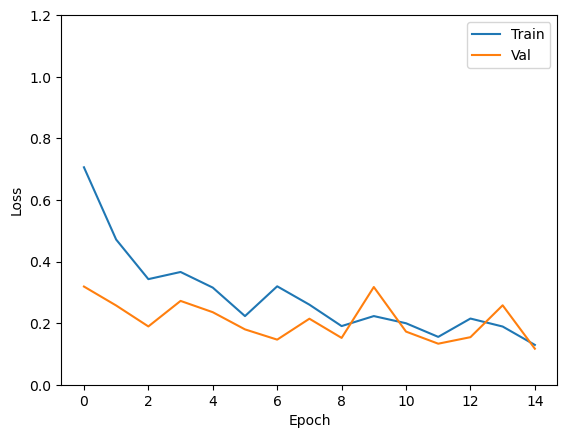

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.ylim(0,1.2)
sns.lineplot(list(range(len(train_loss_list))), train_loss_list)
sns.lineplot(list(range(len(valid_loss_list))), valid_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


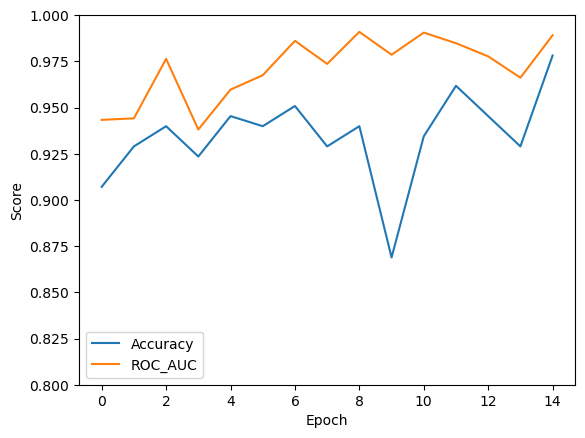

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.ylim(0.8,1)
sns.lineplot(list(range(len(val_acc_list))), val_acc_list)
sns.lineplot(list(range(len(val_auc_list))), val_auc_list)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Accuracy','ROC_AUC'])

In [68]:
%load_ext tensorboard

In [44]:
!taskkill /im tensorboard.exe /f
!del /q %TMP%\.tensorboard-info\*

오류: 프로세스 "tensorboard.exe"을(를) 찾을 수 없습니다.


In [69]:
%tensorboard --logdir=runs

In [26]:
writer.close()

### 12.3.5 예측 및 결과 제출

In [29]:
dataset_test = ImageDataset(test, img_dir=img_dir, transform=transform_test, is_test=True)
 
testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=0)

예측

In [30]:
model.eval() # 모델을 평가 상태로 설정

preds = np.zeros((len(test), 4)) # 예측값 저장용 배열초기화

with torch.no_grad():
    for i, images in enumerate(testloader):
        images = images.to(device)
        outputs = model(images)
        
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

In [31]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('subm_resnet50_cosineAlr.csv', index=False)